In [176]:
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d.axes3d import Axes3D
from pprint import pprint

%matplotlib inline

In [177]:
class TimeValue:
    def __init__(self, time, value):
        self.time = time * 1.0
        self.value = value * 1.0

    def __repr__(self):
        return '({}, {})'.format(self.time, self.value)

In [178]:
class TimeSeries:
    def __init__(self, points=[]):
        self.series = []
        for (time, value) in points:
            self.append(time, value)
        
    def append(self, time, value):
        self.series.append(TimeValue(time, value))
        self.series = sorted(self.series, key=lambda x: x.time)
        
    def time_of(self, value):
        glb = max([t for t, v in self.series when v < value])
        return glb # interpolate this...
        
    @property
    def initial(self):
        return self.series[0]
    
    @property
    def timeline(self):
        return [x.time for x in self.series]
    
    @property
    def values(self):
        return [x.value for x in self.series]
    
    @property
    def components(self, i=None):
        try:
            return list(zip(*self.values))
        except:
            return [self.values]

    def plot(self, toggle='0', loc='best', pad=False, grid=True, marker=None, labels=None, colors=None, lw=1):
        if len(self.components) > 1:
            plt.plot(self.timeline, self.values, marker=marker)
            if loc:
                plt.legend(['x','y','z'][:len(self.components)], loc=loc, numpoints=1)
        else:
            ts = dict()
            ts['0'] = self
            ts['1'] = self.rate_of_change()
            ts['2'] = self.rate_of_change().rate_of_change()
            
            if colors is None:
                colors = [None, None, None]
            else:
                colors = colors * len(toggle) # just in case...

            if labels is None:
                labels = ['position', 'velocity', 'acceleration']
            else:
                labels += [None] * (len(toggle) - len(labels)) # just in case...

            if len(toggle) > 1:
                plt.figure(figsize=(6 * len(toggle), 4))
                
            for i, tog in enumerate(toggle):
                if len(toggle) > 1:
                    plt.subplot(1, len(toggle), toggle.index(tog) + 1)
                plt.plot(ts[tog].timeline, ts[tog].values, marker=marker, 
                         label=labels[i], color=colors[i], lw=lw)
                plt.xlabel('Time')
                if pad:
                    plt.margins(0.05)
                    dt = 0.03 * (self.timeline[-1] - self.timeline[0])
                    plt.axes().set_xlim([self.timeline[0] - dt, self.timeline[-1] + dt])
                if grid:
                    plt.grid(True)
                    plt.gca().axhline(0, c='k')
                if loc and labels[i]:
                    plt.legend(loc=loc, numpoints=1)
                            
    def plot2d(self, toggle='0', x_index=0, y_index=1, title='', colors='', labels=[],
               grid=True, pad=0.10, loc=None, markevery=0, arrows=False, lim=False):
        
        x = dict()
        y = dict()
        
        r = self
        x['0'] = r.components[x_index]
        y['0'] = r.components[y_index]

        v = r.rate_of_change()
        x['1'] = v.components[x_index]
        y['1'] = v.components[y_index]

        a = v.rate_of_change()
        x['2'] = a.components[x_index]
        y['2'] = a.components[y_index]

        color = dict()
        if colors:
            for i, tog in enumerate(toggle):
                color[tog] = colors[i]
        else:
            color['0'] = 'b'
            color['1'] = 'g'
            color['2'] = 'r'            

        label = dict()
        if labels:
            for i, tog in enumerate(toggle):
                label[tog] = labels[i]
        else:
            label['0'] = 'position'
            label['1'] = 'velocity'
            label['2'] = 'acceleration'
                
        for i, tog in enumerate(toggle):
            plt.plot(x[tog], y[tog], c=color[tog], markevery=[-1], 
                     marker='o', mfc='w', mec=color[tog], mew=1)
            if markevery:
                plt.plot(x[tog][:-1], y[tog][:-1], lw=0, markevery=markevery, 
                         marker='.', mec=color[tog])
            
        plt.axes().set_aspect('equal')
        plt.margins(pad)
        if loc:
            plt.legend(numpoints=1, loc=loc, labels=labels)
        plt.title(title)
        
        if grid:
            plt.grid(True)
            plt.axes().axhline(0, c='k')
            plt.axes().axvline(0, c='k')

        if arrows:
            xmin, xmax = plt.xlim()
            ymin, ymax = plt.ylim()
            size = 0.5 * (xmax - xmin) + 0.5 * (ymax - ymin)
            head_size = {
                'head_width': 0.03 * size,
                'head_length': 0.05 * size,
            }
            if '1' in toggle:
                plt.axes().arrow(x['0'][-1], y['0'][-1], x['1'][-1], y['1'][-1], 
                                 fc=color['1'], ec=color['1'], **head_size)
            if '2' in toggle:
                plt.axes().arrow(x['0'][-1], y['0'][-1], x['2'][-1], y['2'][-1], 
                                 fc=color['2'], ec=color['2'], **head_size)
#             xmax = max(xmax,x['0'][-1],x['1'][-1],x['2'][-1])
#             xmin = min(xmin,x['0'][-1],x['1'][-1],x['2'][-1])
#             ymax = max(ymax,y['0'][-1],y['1'][-1],y['2'][-1])
#             ymin = min(ymin,y['0'][-1],y['1'][-1],y['2'][-1])
#             plt.axes().set_xlim([xmin,xmax])
#             plt.axes().set_ylim([ymin,ymax])
        if lim:
            assert len(lim) == 4
            plt.axes().set_xlim([lim[0],lim[1]])
            plt.axes().set_ylim([lim[2],lim[3]])

    def plot3view(self, grid=True, markevery=0):
        assert len(self.components) == 3
        x,y,z = self.components
        fig = plt.figure(figsize=(10, 3.5))
        
        ax1 = plt.subplot(131) # equivalent to: plt.subplot(2, 2, 1)

        ax1.plot(x, y, c='b', markevery=[-1], marker='o', mfc='w', mec='b', mew=1)
        if markevery:
            ax1.plot(x[:-1], y[:-1], lw=0, markevery=markevery, marker='.', mec='b')
        
        ax1.grid(grid)
        ax1.set_aspect('equal')
        ax1.set_xlabel('x')
        ax1.set_ylabel('y')
        ax1.set_title('Top View')
        
        ax2 = plt.subplot(132, sharex=ax1)
        
        ax2.plot(x, z, c='b', markevery=[-1], marker='o', mfc='w', mec='b', mew=1)
        if markevery:
            ax2.plot(x[:-1], z[:-1], lw=0, markevery=markevery, marker='.', mec='b')

        ax2.grid(grid)
        ax2.set_aspect('equal')
        ax2.set_xlabel('x')
        ax2.set_ylabel('z')
        ax2.set_title('Side View (x)')
        
        ax3 = plt.subplot(133, sharey=ax1)
        
        ax3.plot(y, z, c='b', markevery=[-1], marker='o', mfc='w', mec='b', mew=1)
        if markevery:
            ax3.plot(y[:-1], z[:-1], lw=0, markevery=markevery, marker='.', mec='b')
            
        ax3.grid(grid)
        ax3.set_aspect('equal')
        ax3.set_xlabel('y')
        ax3.set_ylabel('z')
        ax3.set_title('Side View (y)')
        fig.tight_layout()
            
    @property
    def intervals(self):
        intervals = []
        for i in range(1, len(self.series)):
            intervals.append((self.series[i - 1], self.series[i]))
        return intervals    
 
    def get_interval(self, time): # closed on left [a, b)
        tmin = min(self.timeline)
        tmax = max(self.timeline)
        if time < tmin:
            return None, self.series[0]
        elif time >= tmax:
            return self.series[-1], None
        else:
            for a, b in self.intervals:
                if a.time <= time and time < b.time:
                    return a, b
    
    def rate_of_change(self):
        ts = TimeSeries()
        for i, (a, b) in enumerate(self.intervals):
            dx = b.value - a.value
            dt = b.time - a.time
            if 1 == 0:
                ts.append(a.time, dx/dt)
            else:
                ts.append(a.time + dt/2, dx/dt)
        return ts
                
    def __call__(self, time):
        a, b = self.get_interval(time)
        
        if b is None: # then extrapolate...
            try:
                c, d = self.intervals[-2] # note: a == d
                dx = d.value - c.value
                dt = d.time - c.time
                return a.value + dx/dt * (time - a.time)
            except:
                return a.value
        else:
            dx = b.value - a.value
            dt = b.time - a.time
            return a.value + dx/dt * (time - a.time)

    def __getitem__(self, index):
        if isinstance(index, int):
            return self.series[index]
        elif isinstance(index, slice):
            return self.series[index]
        else:
            raise TypeError("index must be int or slice")
        
    def __repr__(self):
        import pprint
        return pprint.pformat(self.series)


In [397]:
class Particle():
    def __init__(self, mass=1, t0=0, r0=None, v0=None, p0=None, dim=1, E0=0):
        
        # The only purpose of the following is to redefine the defaults
        # I am *not* error-checking the input parameters...

        if isinstance(r0, np.ndarray):
            dim = max(len(r0), dim)
        if isinstance(v0, np.ndarray):
            dim = max(len(v0), dim)

        if r0 is None:
            if dim == 1:
                r0 = 0
            else:
                r0 = np.zeros(dim)
            
        if v0 is None:
            if dim == 1:
                v0 = 0
            else:
                v0 = np.zeros(dim)
                    
        self.mass = mass
        self.position = TimeSeries([(t0, r0)])
        if self.mass and p0 is None:
            self.momentum = TimeSeries([(t0, self.mass * v0)])
        else:
            self.momentum = TimeSeries([(t0, p0)])
        self.forces = {}
        
        self.energy = TimeSeries([(t0, E0)])

    @property
    def timeline(self):
        return obj.position.timeline
    
    def add_force(self, force, name):
#         if name is None:
#             name = len(self.forces)
        self.forces[name] = ( lambda t, obj=self: force(obj, t) )
        
    def net_force(self, time): # momentum flow or rate of change
        net_force = 0
        for name, force in self.forces.items():
            net_force += force(time)
        return net_force

    def velocity(self, time): # position flow or rate of change
        if time > max(self.momentum.timeline):
            time = max(self.momentum.timeline)
        return self.momentum(time) / self.mass

    def acceleration(self, time):
        r = self.position
        v = r.rate_of_change()
        a = v.rate_of_change()
        if time >= a.timeline[-1]:
            return a.values[-1]
        elif time <= a.timeline[0]:
            return a.values[0]
        else:
            return a(time)
    
    def increment(self, dt, n=1):
        for i in range(n):
            t = max(self.position.timeline)

            if len(self.position.timeline) == 1: # then only go forward half an increment            
                
                next_p = self.momentum(t) + self.net_force(t) * dt/2
                next_E = self.energy(t) + vdot( self.net_force(t), self.velocity(t) ) * dt/2
                
                self.momentum = TimeSeries() # throw out that "initial" value
                self.energy = TimeSeries() # throw out that "initial" value
                
            else: # reach back half an increment to calculate the new momentum value
                
                next_p = self.momentum(t - dt/2) + self.net_force(t) * dt
                next_E = self.energy(t - dt/2) + vdot( self.net_force(t), self.velocity(t) ) * dt

            self.momentum.append(t + dt/2, next_p)
            self.energy.append(t + dt/2, next_E)

            next_r = self.position(t) + self.velocity(t + dt/2) * dt        
            self.position.append(t + dt, next_r)
            
    def plot(self, **kwargs):
        self.position.plot(**kwargs)
        
    def plot2d(self, **kwargs):
        self.position.plot2d(**kwargs)
        
    def plot3view(self, **kwargs):
        self.position.plot3view(**kwargs)

In [1]:
%%time
obj = Particle(r0=1)
obj.add_force(lambda obj, t: -2.5 * obj.position(t), 'spring')
obj.increment(0.1,5000)
obj.plot()

NameError: name 'Particle' is not defined

In [2]:
%%time

dt = 0.1

v = 0.0
x = 1.0
m = 1.0
k = 2.5
t = 0.0

count = 0

t_list = []
x_list = []
while t < 500:
    f = -k * x
    a = f / m
    v = v + a * dt
    x = x + v * dt
    t_list.append(t)
    x_list.append(x)
    t = t + dt

plt.plot(t_list, x_list)
plt.show()

NameError: name 'plt' is not defined

In [425]:
max(x_list), max(obj.position.values)

(1.0031390686362893, 1.0)

In [180]:
# class PhysicalSystem():
#     def __init__(self, initial=[]):
#         self.objs = list()
#         for (mass, r0, v0) in initial:
#             self.objs.append(Particle(mass=mass, r0=r0, v0=v0))
                    
#         for obj1 in self.objs:
#             for obj2 in self.objs:
#                 if obj1 != obj2: # no self-interactions !
#                     internal_force = lambda t, obj1=obj1, obj2=obj2: self.interaction(obj1, obj2, t)
#                     obj1.forces.append(internal_force)
                    
#     def interaction(self, obj1, obj2, time):
#         return 0
                    
#     def increment(self, dt, n=1):
#         for i in range(n):
#             for obj in self.objs:
#                 obj.increment(dt)
                
#     def plot(self):
#         for i, obj in enumerate(self.objs):
#             obj.position.plot(legend_loc=None)
            
#     def plot2d(self, colors='bgrcmyk'*9, **kwargs):
#         for i, obj in enumerate(self.objs):
#             obj.position.plot2d(color=colors[i], **kwargs)

In [181]:
# import cmath

# class RigidObject(Particle):
#     def __init__(self, mass=1, t0=0, r0=0, p0=0, v0=None, moi=1, q0=1+0j, L0=0+0j, w0=None):
#         Particle.__init__(self, mass, t0, r0, p0, v0)
#         self.moi = moi
#         self.attitude = TimeSeries([(t0, q0)])
#         self.angular_displacement = TimeSeries([(t0, cmath.phase(q0))])
#         if self.moi and w0 is not None:
#             self.angular_momentum = TimeSeries([(t0, self.moi * w0)])
#         else:
#             self.angular_momentum = TimeSeries([(t0, L0)])
#         self.torques = []
    
#     def add_torque(self, torque):
#         self.torques.append(lambda t, obj=self: torque(obj, t))        
        
#     def net_torque(self, time): # angular_momentum flow or rate of change
#         net_torque = 0+0j
#         for tau in self.torques:
#             net_torque += tau(time)
#         return net_torque

#     def rotational_velocity(self, time): # attitude flow or rate of change
#         if time > max(self.angular_momentum.timeline):
#             time = max(self.angular_momentum.timeline)
#         return self.angular_momentum(time) / self.moi
    
#     def increment(self, dt, n=1):
#         for i in range(n):
#             Particle.increment(self, dt, 1)
            
#             t = max(self.attitude.timeline)

#             if len(self.attitude.timeline) == 1: # then only go forward half an increment            
#                 next_L = self.angular_momentum(t) + self.net_torque(t) * dt/2
#                 self.angular_momentum = TimeSeries() # throw out that "initial" value
#             else: # reach back half an increment to calculate the new momentum value
#                 next_L = self.angular_momentum(t - dt/2) + self.net_torque(t) * dt                

#                 q = self.angular_displacement(t - dt)
#                 q += self.rotational_velocity(t + dt/2) * dt
#                 self.angular_displacement.append(t, q)

#             self.angular_momentum.append(t + dt/2, next_L)
#             rotor = np.exp( 1j * self.rotational_velocity(t + dt/2) * dt )
#             next_attitude = self.attitude(t) * rotor
#             self.attitude.append(t + dt, next_attitude)

In [182]:
def vmag(a):
    return np.sqrt(vdot(a, a))

def vdir(a):
    if vmag(a) == 0:
        vdir = np.array([1]+[0]*(len(a)-1)) # it doesn't matter since magnitude = 0
    else:
        vdir = a / vmag(a)
    return vdir
        
def vang(a, deg=True, x_index=0, y_index=1):
    vang = np.arctan2(a[y_index], a[x_index])
    if deg:
        vang = vang * 180/np.pi
    return vang

def vect(mag, ang, deg=True):
    if deg:
        ang = ang * np.pi/180
    return mag * np.array([np.cos(ang), np.sin(ang)])

def vdot(a, b):
    if isinstance(a, float):
        return a * b

    assert len(a) == len(b)    
    vdot = 0
    for i in range(len(a)):
        vdot += a[i] * b[i]
    return vdot

In [183]:
def weight(obj):
    return np.array([0, -9.8 * obj.mass])

def support(obj, t, normal=np.array([0,1])):
    normal = vdir(normal)
    net_force = obj.net_force(t)
    net_force_proj = vdot(net_force, normal)
    support = -net_force_proj * normal
    return support

def friction(obj, t, support, mu_s=1, mu_k=1):
    net_force = obj.net_force(t)
    v = obj.velocity(t)
    
    frickin = False
    if vmag(v) > 0:
        frickin = True
    if vmag(net_force) > mu_s * vmag(support): # maximum static friction
        frickin = True
        
    if frickin: # then use kinetic friction
        friction = -mu_k * vmag(support) * vdir(v)
    else: # create equilibrium
        friction = -net_force
        
    return friction

# Chapter 6

**Problem 003**

The brakes of a truck cause it to slow down by applying a retarding force of 3000 newtons to the truck over a distance of 850 meters. What is the work done by this force on the truck? Is the work positive or negative? Why?

*Answer:* −2.6E+6 joules

In [164]:
dt = 0.1
obj = Particle(mass=1000,v0=100) # we have to get the position to at least 850, but other  
                                 # than that, the answer is independent of these values
obj.add_force(lambda obj, t: -3000.0)

while True:
    obj.increment(dt)
    if obj.position.values[-1] > 850:
        break

t = max(obj.position.timeline)
obj.position(t)
print('{:.3g}'.format(obj.energy(t)))

-2.58e+06


**Problem 005**

Suppose that +1100 joules of work is done by a force (magnitude 30.0 newtons) in moving the suitcase a distance of 50.0 meters. At what angle is the force oriented with respect to the ground?

*Answer:* 42.8°

The angle of the external force = 42.8°
The total displacement = 50.1
The change in energy = 1098.1


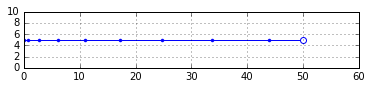

In [263]:
dt = 0.005

q = 45
q = 0
for dq in [10,1,0.1]:
    while True:
        q += dq
        
        obj = Particle(r0=np.array([0,5]))

        w = np.array([0,-9.8 * obj.mass])
        obj.add_force(lambda obj, t: w, 'weight')

        f = 30 * np.array([np.cos(q * np.pi/180),np.sin(q * np.pi/180)])
        obj.add_force(lambda obj, t: f, 'pushing')

        t = obj.position.timeline[-1]

        s = support(obj, t)
        obj.add_force(lambda obj, t: s, 'support')

        while True:
            obj.increment(dt)
            x,y = obj.position.values[-1]
            if x > 50:
                break

        t = max(obj.position.timeline)
        if obj.energy(t) < 1100:
            q -= dq
            break
            
t = max(obj.position.timeline)
x,y = obj.position(t)
E = obj.energy(t)

print('The angle of the external force = {:.1f}°'.format(q))
print('The total displacement = {:.1f}'.format(x))
print('The change in energy = {:.1f}'.format(E))

obj.plot2d(lim=[0,60,0,10],markevery=50)

**Problem 006**

A person pushes a 16.0-kilogram shopping cart at a constant velocity for a distance of 22.0 meters. She pushes in a direction below the horizontal **(angle = \_\_°)**. A 48.0-newton frictional force opposes the motion of the cart. (a) What is the magnitude of the force that the shopper exerts? Determine the work done by (b) the pushing force, (c) the frictional force, and (d) the gravitational force.

*Answer:* (a) 54.9 newtons (b) 1060 joules (c) −1060 joules (d) 0 joules

In [184]:
mag_ext_force = 0
for dF in [100, 10, 1, 0.1, 0.01]:
    while True:
        mag_ext_force += dF

        obj = Particle(mass=16, v0=np.array([1,0]))
        obj.add_force(lambda obj, t: weight(obj))
        obj.add_force(lambda obj, t: np.array([mag_ext_force, 0]))

        t = obj.position.timeline[-1]

        x = support(obj, t)
        obj.add_force(lambda obj, t: x)

#         y = friction(obj, t, support=x, mu_s=0.760, mu_k=0.410)
#         obj.add_force(lambda obj, t: y)

        y = np.array([-48.0,0])
        obj.add_force(lambda obj, t: y)

        obj.increment(0.1,10)

        ax, ay = obj.acceleration(t)

        if ax > 0.00001:
            break

    mag_ext_force -= dF 
    
print('Pushing force = {:.1f} newtons'.format(mag_ext_force))

Pushing force = 48.0 newtons


**Problem 008**

A person pulls a toboggan for a distance of 35.0 meters along the snow with a rope directed 25.0° above the snow. The tension in the rope is 94.0 newtons. (a) How much work is done on the toboggan by the tension force? (b) How much work is done if the same tension is directed parallel to the snow?

*Answer:* (a) 2980 joules (b) 3290 joules

Final x-position = 35.0
Work done by the pulling force = 2983 newtons
Final speed = 24.4 m/s
Time taken = 2.9 seconds


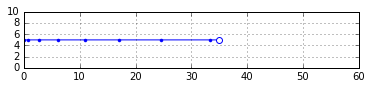

Final x-position = 35.0
Work done by the pulling force = 3290 newtons
Final speed = 25.7 m/s
Time taken = 2.7 seconds


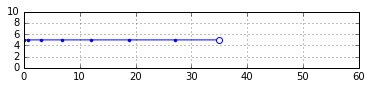

In [230]:
for q in [25,0]:
    obj = Particle(mass=10,r0=np.array([0,5])) # note: mass must be large enough to provide enough weight
                                               # to keep the toboggan on the ground

    q *= np.pi/180
    f = 94 * np.array([np.cos(q), np.sin(q)])
    obj.add_force(lambda obj, t: f, 'pulling')

    w = np.array([0, -9.8 * obj.mass])
    obj.add_force(lambda obj, t: w, 'weight')

    t = obj.position.timeline[-1]

    s = support(obj, t)
    obj.add_force(lambda obj, t: s, 'support')

    while True:
        obj.increment(0.002)
        x,y = obj.position.values[-1]
        if x > 35.0:
            break

    t = obj.position.timeline[-1]
    print('Final x-position = {:.1f}'.format(obj.position.values[-1][0]))
    print('Work done by the pulling force = {:.0f} newtons'.format(obj.energy(t)))
    print('Final speed = {:.1f} m/s'.format(vmag(obj.velocity(t))))
    print('Time taken = {:.1f} seconds'.format(t))

    obj.plot2d(lim=[0,60,0,10],markevery=200)
    plt.show()

**Problem 013**

A fighter jet is launched from an aircraft carrier with the aid of its own engines and a steam-powered catapult. The thrust of its engines is 2.3E+5 netwons. In being launched from rest it moves through a distance of 87 meters and has a kinetic energy of 4.5E+7 joules at lift-off. What is the work done on the jet by the catapult?

*Answer:* 2.5E+7 joules

In [253]:
f = 0
for df in [1000,100,10,1]:
    for _ in range(1000):
        f += df

        obj = Particle(mass=10000,v0=0)
        obj.add_force(lambda obj, t: 2.3e5, 'thrust')
        obj.add_force(lambda obj, t: f, 'catapult')
        
        while True:
            obj.increment(0.01)
            if obj.position.values[-1] > 87:
                break

        if obj.energy.values[-1] > 4.5e7:
            f -= df
            break
print('{:.2e}'.format(f*87)) ## CHEAT !!


2.51e+07


**Problem 019**

The hammer throw is a track-and-field event in which a 7.3-kilogram ball (the "hammer"), starting from rest, is whirled around in a circle several times and released. It then moves upward on the familiar curving path of projectile motion. In one throw, the hammer is given a speed of 29 m/s. For comparison, a .22 caliber bullet has a mass of 2.6 grams and, starting from rest, exits the barrel of a gun at a speed of 410 m/s. Determine the work done to launch the motion of (a) the hammer and (b) the bullet.

*Answer:* (a) 3100 joules (b) 220 joules

Radius of the circle = 7.4 meters


39.610240007888329

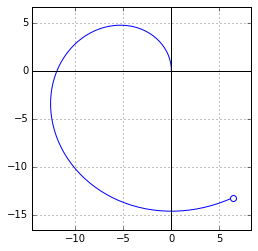

In [381]:
dt = 0.1

r0 = np.array([0,0])
v0 = np.array([0,2])
obj = Particle(mass=7.3,r0=r0,v0=v0)

t = max(obj.position.timeline)

max_d = 0
for _ in range(150):
    
    if 'tangential' in obj.forces:
        del obj.forces['tangential']

    mag_f_tang = 1
    f_tang = mag_f_tang * np.array([np.cos(vang(p) * np.pi/180),np.sin(vang(p) * np.pi/180)])
    obj.add_force(lambda obj, t: f_tang, 'tangential')


    mag_f_cent = obj.mass

    t = max(obj.position.timeline)
    v = obj.velocity(t) + f_tang * dt / obj.mass
    q = vang(v) + 90
    
    # the following is a geometric correction to guarentee the resultant velocity 
    # has the same speed as the one before it --- however, this messes up the energy calculation
    p = obj.momentum(t)
    if len(obj.position.timeline) == 1:
        dq = 0.5 * np.arccos(1 - 0.5 * (mag_f_cent * dt/2) ** 2 / vmag(p + f_tang * dt/2) ** 2) * 180/np.pi
    else:
        dq = 0.5 * np.arccos(1 - 0.5 * (mag_f_cent * dt) ** 2 / vmag(p + f_tang * dt) ** 2) * 180/np.pi
    q += dq
    
    if 'centripetal' in obj.forces:
        del obj.forces['centripetal']

    f_cent = mag_f_cent * np.array([np.cos(q * np.pi/180),np.sin(q * np.pi/180)])
    obj.add_force(lambda obj, t: f_cent, 'centripetal')

    obj.increment(dt)
    max_d = max(max_d, vmag(obj.position.values[-1] - r0))

radius = max_d / 2

print('Radius of the circle = {:.1f} meters'.format(radius))
obj.plot2d()
obj.energy.values[-1]

**Problem 029**

A 75.0-kilogram skier rides a 2830-meter-long lift to the top of a mountain. The lift makes an angle of 14.6° with the horizontal. What is the change in the skier's gravitational potential energy?

*Answer:* 5.24E+5 joules

In [ ]:
obj = Particle(mass=75)


**Problem 033**

A bicyclist rides 5.0 kilometers due east, while the resistive force from the air has a magnitude of 3.0 newtons and points due west. The rider then turns around and rides 5.0 kilometers due west, back to her starting point. The resistive force from the air on the return trip has a magnitude of 3.0 newtons and points due east. (a) Find the work done by the resistive force during the round trip. (b) Based on your answer to part (a), is the resistive force a conservative force? Explain.

*Answer:* (a) −3.0E+4 joules (b) No

**Problem 038**

The skateboarder in the drawing starts down the left side of the ramp with an initial speed of 5.4 m/s. Neglect nonconservative forces, such as friction and air resistance, and find the height of the highest point reached by the skateboarder on the right side of the ramp. 

*Answer:* 1.5 meters

**Problem 041**

A 47.0-gram golf ball is driven from the tee with an initial speed of \_\_ and rises to a height of 24.6 meters. (a) Neglect air resistance and determine the kinetic energy of the ball at its highest point. (b) What is its speed when it is 8.0 meters below its highest point?

*Answer:* (a) 52.2 joules (b) 48.8 joules

In [ ]:
mass = 0.047


**Problem 064**

You are working out on a rowing machine. Each time you pull the rowing bar (which simulates the oars) toward you, it moves a distance of 1.2 meters in a time of 1.5 seconds. The readout on the display indicates that the average power you are producing is 82 watts. What is the magnitude of the force that you exert on the handle?

*Answer:* 100 newtons

**Problem 068**

In 2.0 minutes, a ski lift raises four skiers at constant speed to a height of 140 meters. The average mass of each skier is 65 kilograms. What is the average power provided by the tension in the cable pulling the lift?

*Answer:* 3000 watts

**Problem 077**

A 2.00-kilogram rock is released from rest at a height of 20.0 meters. Ignore air resistance and determine the kinetic energy, gravitational potential energy, and total mechanical energy at each of the following heights: 20.0, 10.0, and 0 meters.


*Answer:* (a) 0, 392, 392 joules (b) 196, 196, 392 joules (c) 392, 0, 392 joules

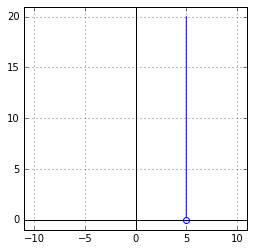

In [408]:
dt = 0.001

obj = Particle(mass=2,r0=np.array([5,20]))
obj.add_force(lambda obj, t: np.array([0,-9.8 * obj.mass]), 'weight')
while True:
    obj.increment(dt)
    x,y = obj.position.values[-1]
    if y < 0:
        break

obj.plot2d(lim=[-11,11,-1,21])
plt.show()

# KE = int Fnet(t).v(t) dt

KE = TimeSeries()
for t in obj.timeline[1:-1]:
    if len(KE.values) > 0:
        x = KE.values[-1]
    else:
        x = 0
    x += vdot(obj.net_force(t), obj.velocity(t)) * dt
    KE.append(t, x)

In [409]:
obj.position.time_of(10)

AttributeError: 'TimeSeries' object has no attribute 'time_of'

# Chapter 7

**Problem 001**

A 46-kilogram skater is standing still in front of a wall. By pushing against the wall she propels herself backward with a velocity of −1.2 m/s. Her hands are in contact with the wall for 0.80 seconds. Ignore friction and wind resistance. Find the magnitude and direction of the average force she exerts on the wall (which has the same magnitude as, but opposite direction to, the force that the wall applies to her).

*Answer:* +69 newtons

**Problem 005**

A volleyball is spiked so that its incoming velocity of +4.0 m/s is changed to an outgoing velocity of −21 m/s. The mass of the volleyball is 0.35 kilograms. What impulse does the player apply to the ball?

*Answer:* −8.7 kg-m/s

**Problem 007**

A hockey goalie is standing on ice. Another player fires a puck (mass = 0.17 kilograms) at the goalie with a velocity of +65 m/s. (a) If the goalie catches the puck with his glove in a time of 5.0E−3 seconds, what is the average force (magnitude and direction) exerted on the goalie by the puck? (b) Instead of catching the puck, the goalie slaps it with his stick and returns the puck straight back to the player with a velocity of −65 m/s. The puck and stick are in contact for a time of 5.0E−3 seconds. Now what is the average force exerted on the goalie by the puck?

*Answer:* (a) 2200 newtons (b) 4400 newtons

**Problem 019**

A lumberjack (mass = 98 kilograms) is standing at rest on one end of a floating log (mass = 230 kilograms) that is also at rest. The lumberjack runs to the other end of the log, attaining a velocity of +3.6 m/s relative to the shore, and then hops onto an identical floating log that is initially at rest. Neglect any friction and resistance between the logs and the water. (a) What is the velocity of the first log just before the lumberjack jumps off? (b) Determine the velocity of the second log if the lumberjack comes to rest on it.

*Answer:* (a) −1.5 m/s (b) +1.1 m/s

**Problem 021**

A two-stage rocket moves in space at a constant velocity of 4900 m/s. The two stages are then separated by a small explosive charge placed between them. Immediately after the explosion the velocity of the 1200-kilogram upper stage is 5700 m/s in the same direction as before the explosion. What is the velocity (magnitude and direction) of the 2400-kilogram lower stage after the explosion?

*Answer:* +4500 m/s

**Problem 029**

A 2.50-gram bullet, traveling at a speed of 425 m/s, strikes the wooden block of a ballistic pendulum. The block has a mass of 215 grams. (a) Find the speed of the bullet–block combination immediately after the collision. (b) How high does the combination rise above its initial position?

*Answer:* (a) 4.89 m/s (b) 1.22 meters

**Problem 031**

Batman (mass = 91 kilograms) jumps straight down from a bridge into a boat (mass = 510 kilograms) in which a criminal is fleeing. The velocity of the boat is initially +11 m/s. What is the velocity of the boat after Batman lands in it?

*Answer:* +9.3 m/s

**Problem 033**

A 5.00-kilogram ball, moving to the right at a velocity of on a frictionless table, collides head-on with a stationary 7.50-kg ball. Find the final velocities of the balls if the collision is (a) elastic and (b) completely inelastic.

*Answer:* (a) −0.400 m/s and +1.60 m/s (b) +0.800 m/s

**Problem 035**

A projectile (mass = 0.20 kilograms) is fired at and embeds itself in a stationary target (mass = 2.50 kilograms). With what percentage of the projectile's incident kinetic energy does the target (with the projectile in it) fly off after being struck?

*Answer:* 7.4%

**Problem 041**

A 50.0-kilogram skater is traveling due east at a speed of 3.00 m/s. A 70.0-kilogram skater is moving due south at a speed of 7.00 m/s. They collide and hold on to each other after the collision, managing to move off at an angle south of east. Find (a) the angle and (b) the speed, assuming that friction can be ignored.

*Answer:* (a) 73.0° (b) 4.28 m/s

# Chapter 8

**Problem 001**

A pitcher throws a curveball that reaches the catcher in 0.60 seconds. The ball curves because it is spinning at an average angular velocity of 330 rpm (assumed constant) on its way to the catcher's mitt. What is the angular displacement of the baseball (in radians) as it travels from the pitcher to the catcher?

*Answer:* 21 radians

**Problem 003**

The earth spins on its axis once a day and orbits the sun once a year (365¼ days). Determine the average angular velocity (in rad/s) of the earth as it (a) spins on its axis and (b) orbits the sun. In each case, take the positive direction for the angular displacement to be the direction of the earth's motion.

*Answer:* (a) 7.3E−5 rad/s (b) 2.0E−7 rad/s

**Problem 009**

A Ferris wheel rotates at an angular velocity of 0.24 rad/s. Starting from rest, it reaches its operating speed with an average angular acceleration of 0.030 rad/s². How long does it take the wheel to come up to operating speed?

*Answer:* 8.0 seconds

**Problem 021**

A gymnast is performing a floor routine. In a tumbling run she spins through the air, increasing her angular velocity from 3.00 to 5.00 rev/s while rotating through one-half of a revolution. How much time does this maneuver take?

*Answer:* 0.125 seconds

**Problem 023**

A wind turbine is initially spinning at a constant angular speed. As the wind's strength gradually increases, the turbine experiences a constant angular acceleration of 0.140 rad/s². After making 2870 revolutions, its angular speed is 137 rad/s. (a) What is the initial angular velocity of the turbine? (b) How much time elapses while the turbine is speeding up?

*Answer:* (a) 117 rad/s (b) 140 seconds

**Problem 025**

The wheels of a bicycle have an angular velocity of +20.0 rad/s. Then, the brakes are applied. In coming to rest, each wheel makes an angular displacement of +15.92 revolutions. (a) How much time does it take for the bike to come to rest? (b) What is the angular acceleration (in rad/s²) of each wheel?

*Answer:* (a) 10.0 seconds (b) −2.00 rad/s²

**Problem 037**

A string trimmer is a tool for cutting grass and weeds; it utilizes a length of nylon "string" that rotates about an axis perpendicular to one end of the string. The string rotates at an angular speed of 47 rev/s, and its tip has a tangential speed of 54 m/s. What is the length of the rotating string?

*Answer:* 0.18 meters

**Problem 039**

The take-up reel of a cassette tape has an average radius of 1.4 centimeters. Find the length of tape (in meters) that passes around the reel in 13 seconds when the reel rotates at an average angular speed of 3.4 rad/s.

*Answer:* 0.62 meters

**Problem 042**

A person lowers a bucket into a well by turning the hand crank (axle diameter = 0.100 meters, crank diameter = 0.400 meters). The crank handle moves with a constant tangential speed of 1.20 m/s on its circular path. The rope holding the bucket unwinds without slipping on the barrel of the crank. Find the linear speed with which the bucket moves down the well. 

*Answer:* 0.300 m/s

**Problem 053**

A motorcycle accelerates uniformly from rest and reaches a linear speed of 22.0 m/s in a time of 9.00 seconds. The radius of each tire is 0.280 meters. What is the magnitude of the angular acceleration of each tire?

*Answer:* 8.71 rad/s²

**Problem 054**

An automobile tire has a radius of 0.330 meters, and its center moves forward with a linear speed of 15.0 m/s. (a) Determine the angular speed of the wheel. (b) Relative to the axle, what is the tangential speed of a point located 0.175 meters from the axle?

*Answer:* (a) 45.5 rad/s (b) 7.96 m/s

**Problem 056**

Suppose you are riding a stationary exercise bicycle, and the electronic meter indicates that the wheel is rotating at 9.1 rad/s. The wheel has a radius of 0.45 meters. If you ride the bike for 35 minutes, how far would you have gone if the bike could move?

*Answer:* 8600 meters

**Problem 068**

During a tennis serve, a racket is given an angular acceleration of magnitude 160 rad/s². At the top of the serve, the racket has an angular speed of 14 rad/s. If the distance between the top of the racket and the shoulder is 1.5 meters, find the magnitude of the total acceleration of the top of the racket.

*Answer:* 380 m/s²

**Problem 069**

The drawing shows a chain-saw blade. The rotating sprocket tip at the end of the guide bar has a radius of 4.0E−2 meters. The linear speed of a chain link is 5.6 m/s. Find the angular speed of the sprocket tip in rev/s. 

*Answer:* 22 rev/s

# Chapter 9

**Problem 001**

The wheel of a car has a radius of 0.350 meters. The engine of the car applies a torque of 295 newtons to this wheel, which does not slip against the road surface. Since the wheel does not slip, the road must be applying a force of static friction to the wheel that produces a counter-torque. Moreover, the car has a constant velocity, so this counter-torque balances the applied torque. What is the magnitude of the static frictional force?

*Answer:* 843 newtons

**Problem 006**

A square, 0.40 meters on a side, is mounted so that it can rotate about an axis that passes through the center of the square. The axis is perpendicular to the plane of the square. A force of 15 newtons lies in this plane and is applied to the square. What is the magnitude of the maximum torque that such a force could produce?

*Answer:* 4.2 newton-meters

**Problem 012**

The drawing shows a person (weight = 584 newtons) doing push-ups. Find the normal force exerted by the floor on each hand and each foot, assuming that the person holds this position. 

*Answer:* (a) 196 newtons (b) 96 newtons

**Problem 015**

A person exerts a horizontal force of 190 newtons in the test apparatus shown in the drawing. Find the horizontal force (magnitude and direction) that his flexor muscle exerts on his forearm. (Muscle is 0.054 meters from elbow joint, apparatus is 0.34 meters from the joint.)

*Answer:* 1200 newtons

**Problem 031**

A CD has a mass of 17 grams and a radius of 6.0 centimeters. When inserted into a player, the CD starts from rest and accelerates to an angular velocity of 21 rad/s in 0.80 seconds. Assuming the CD is a uniform solid disk, determine the net torque acting on it.

*Answer:* 8.0E−4 newton-meters

**Problem 033**

A solid circular disk has a mass of 1.2 kilograms and a radius of 0.16 meters. Each of three identical thin rods has a mass of 0.15 kilograms. The rods are attached perpendicularly to the plane of the disk at its outer edge to form a three-legged stool (see the drawing). Find the moment of inertia of the stool with respect to an axis that is perpendicular to the plane of the disk at its center. 

(Hint: When considering the moment of inertia of each rod, note that all of the mass of each rod is located at the same perpendicular distance from the axis.)

*Answer:* 0.027 kg-m²

**Problem 034**

A ceiling fan is turned on and a net torque of 18 newton-meters is applied to the blades. The blades have a total moment of inertia of 0.22 kg-m². What is the angular acceleration of the blades?

*Answer:* 8.2 rad/s²

**Problem 048**

Calculate the kinetic energy that the earth has because of (a) its rotation about its own axis and (b) its motion around the sun. Assume that the earth is a uniform sphere and that its path around the sun is circular. For comparison, the total energy used in the United States in one year is about 1.1E+20 joules.

*Answer:* (a) 2.57E+29 joules (b) 2.67E+33 joules

**Problem 051**

A flywheel is a solid disk that rotates about an axis that is perpendicular to the disk at its center. Rotating flywheels provide a means for storing energy in the form of rotational kinetic energy and are being considered as a possible alternative to batteries in electric cars. The gasoline burned in a 300-mile trip in a typical midsize car produces about 1.2E+9 joules of energy. How fast would a 13-kilograms flywheel with a radius of 0.30 m have to rotate to store this much energy? Give your answer in rpm.

*Answer:* 6.1E+5 rpm

**Problem 063**

A thin rod has a length of 0.25 meters and rotates in a circle on a frictionless tabletop. The axis is perpendicular to the length of the rod at one of its ends. The rod has an angular velocity of 0.32 rad/s and a moment of inertia of 1.1E−3 kg-m². A bug standing on the axis decides to crawl out to the other end of the rod. When the bug (mass = 4.2E−3 kilograms) gets where it's going, what is the angular velocity of the rod?

*Answer:* 0.26 rad/s

**Problem 064**

As seen from above, a playground carousel is rotating counterclockwise about its center on frictionless bearings. A person standing still on the ground grabs onto one of the bars on the carousel very close to its outer edge and climbs aboard. Thus, this person begins with an angular speed of zero and ends up with a nonzero angular speed, which means that he underwent a counterclockwise angular acceleration. The carousel has a radius of 1.50 meters, an initial angular speed of 3.14 rad/s, and a moment of inertia of 125 kg-m². The mass of the person is 40.0 kilograms. Find the final angular speed of the carousel after the person climbs aboard.

*Answer:* 1.83 rad/s

**Problem 071**

A solid cylindrical disk has a radius of 0.15 meters. It is mounted to an axle that is perpendicular to the circular end of the disk at its center. When a 45-newton force is applied tangentially to the disk, perpendicular to the radius, the disk acquires an angular acceleration of 120 rad/s². What is the mass of the disk?

*Answer:* 5.0 kilograms

**Problem 073**

A rotating door is made from four rectangular sections (1.2 meters long), as indicated in the drawing. The mass of each section is 85 kilograms. A person pushes on the outer edge of one section with a force of 68 newtons that is directed perpendicular to the section. Determine the magnitude of the door's angular acceleration. 

*Answer:* 0.50 rad/s²

# Chapter 10

- 1,4,7,11,17,21,32,33,43,44,51,53,76,80

# Chapter 11

- 1,3,11,12,20,33,35,40,41,56,57,63,73,93

# Chapter 12

- 3,11,15,28,29,35,47,57,59,63,92

# Chapter 13

- 2,5,9,22,25,29,37

# Chapter 14

- 5,15,17,35,40,41,49,53,57

# Chapter 15

- 1,6,8,21,22,44,47,51,63,64,78

# Chapter 16

- 1,3,4,5,12,35,53,65,67,69,76,80,92,93

# Chapter 17

- 2,3,12,19,21,23,27,33,43,45,55,59

# Chapter 24

- 1,2,3,7,15,17,35,36

# Chapter 25

- 5,6,16,20,21,38,39

# Chapter 26

- 1,10,11,13,45,50,53,75,77,105,108,113,115

# Chapter 18

- 1,5,10,11,12,17,18, 31,33,40,66,67,68

# Chapter 19

- 3,5,6,13,18,21,25,32,35,37,42,45,59,61

# Chapter 20

- 3,4,12,15,23,25,27,34,37,42,43,54,55,57,110,116

# Chapter 20

- 64,65,67,79,83,93,97,103,105,112

# Chapter 21

- 3,4,7,13,14,15,19,31,35,55,58,59,76

# Chapter 22

- 3,5,11,13,15,21,22,34,36,49,50,51,55,60,61,72,73,74

# Chapter 23

- 2,5,9,10,13,17,19,22,31,33,46,47,48

# Chapter 24

- 4,49,51,52

# Chapter 28

- 1,3,4,8,9,10,21,25,27,29,30,43,45

# Chapter 29

- 1,3,5,7,15,18,19,25,26,37,39,43